<h1 align=center><font size = 5>SPE Europe Energy GeoHackathon</font></h1>

Society of Petroleum Engieers|  ERCE Equipoise | Geothermal Challenge  
:-------------------------:|:-------------------------:|:-------------------------:
<a href="https://www.spehackathon-eu.com"> <img src = "https://upload.wikimedia.org/wikipedia/en/thumb/4/42/Society_of_Petroleum_Engineers_Logo.svg/1200px-Society_of_Petroleum_Engineers_Logo.svg.png" width = 200 /> | <a href="https://www.erce.energy/"> <img src = "https://energycouncil.com/wp-content/uploads/ERCE.png" width = 200/> | <img src = "https://solutions.vallourec.com/-/media/Solutions-img/Low-Carbon-Energy/Medias/Geothermal-energy/Header-Corner_Geothermal.ashx" width = 200/>
    


<h1 align=center><font size = 4> Team ERCE - Munish Kumar, Kanna Swaminathan & Ivan Maulana </font></h1>
<h1 align=center><font size = 3> 2021 </font></h1>

In [1]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import math

import time
import re
import requests
import pickle
import os
import glob
import scipy
import sys
import warnings

import plotly.express as px
import plotly.graph_objects as go 

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set()

from sklearn.linear_model import LinearRegression

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
# Change dir_name = Path Name as needed
dir_name = r'C:\Users\mkumar\Documents\GitHub\@Working\SPE_GeoHackathon\4_Submission_14122021\Sect3.2_Static_Properties\Input'
filename_suffix = 'txt'
filename_suffix2 = 'csv'

font = {'family': 'arial',
    'color':  'blue',
    'weight': 'normal',
    'size': 16,
   }

Functions to read text files, plot and process for static properties

In [3]:
def interp_well(dir_name, base_filename, filename_suffix, font):
    skiprows = 7
    csvs_sht = os.path.join(dir_name, base_filename + '.' + filename_suffix)

    data = pd.read_csv(csvs_sht, delimiter = "\t", skiprows = skiprows, header=None)
    data.columns = ['time(day)', 'water_rate(m3/d)', 'BHP(bars)']
    data.drop(index=data.index[0], axis=0, inplace=True)
    data = data.apply(pd.to_numeric)
    
    #Check the data
    print("------------------Checking the Data---------------")   
    print(data.head())
    print("------------------Type of Data---------------")   
    print(data.info())
    print("------------------Checking for missing points visually---------------")   
    
    fig, ax = plt.subplots(figsize=(25,8))
    sns.heatmap(data.isnull(), ax=ax, cmap="magma")
    plt.grid()
    plt.show()

    # 2 functions. 
    # 1. Function "crossplot" plots the data
    # 2. Function "ddplot" only plots the drawdown data   
    time = data['time(day)'].to_numpy() # x-value
    pressure = data['BHP(bars)'].to_numpy() # y-value

    crossplot(time, pressure, font)
    time_drop, pressure_drop = ddplot(time, pressure, font)
    
    data_out = [time_drop, pressure_drop]    
    df_out = pd.DataFrame(data_out).transpose()
    df_out.columns = ['time(day)', 'BHP(bars)']
    return df_out

In [4]:
def crossplot(time, pressure, font):
   
    fig, ax = plt.subplots(figsize=(10,10))
        
    plt.scatter(time, pressure, label="Well Test", s=25, c = 'r', linewidth=3, zorder=1)
    plt.plot(time, pressure, label="Well Test", c = 'b', linewidth=3, zorder=2)
    
    print("---------------Linear-Linear Plot---------------")
    plt.title('Pressure vs. Time', fontdict=font)
    plt.legend(loc='upper left')
    plt.xlabel('Time / day', fontdict=font)
    plt.ylabel('Pressure / bars', fontdict=font)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.show()
    return

In [5]:
# Function is only focus on the start of build-up/ end of draw-done
def ddplot(time, pressure, font):
    
    fig, ax = plt.subplots(figsize=(10,10))
        
    # Only plotting draw down pressure
    for i in range(len(pressure)):
        if pressure[i+1] > pressure[i]:
            break
    
    pressure_drop = pressure[:i+1]
    time_drop = time[:i+1]

    print("---------------Semi Log Plot---------------")
    plt.semilogx(time_drop, pressure_drop, c = 'b', linewidth=3)
    
    plt.title('Pressure vs. log(Time)', fontdict=font)
    plt.xlabel('log(Time / day)', fontdict=font)
    plt.ylabel('Pressure / bars', fontdict=font) 
    plt.tick_params(axis='x', which='minor')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.show()
    return time_drop, pressure_drop

In [6]:
# Function is evaluate permeability using linear regression
def transient_flow_analysis(df1, lf_start, lf_end, h, q, font):
    
    day_to_second = 86400   # conversion factor day to second, s
    B = 1.0                 # volume factor, V_res/V_surf, dimensionless
    H = h                   # thickness, m
    Q = q/day_to_second     # rate, m3/s
    mu  = 1e-3              # Fluid is brine, viscosity of water, Pa/s
    con = -1e15             # Conversion from m2 to mD   
    
    time = df1['time(day)'].to_numpy() * day_to_second      # x-value
    pressure = df1['BHP(bars)'].to_numpy() * 100000        # y-value
    
    lf_start = lf_start * day_to_second
    lf_end = lf_end * day_to_second
    
    for i in range(len(time)):
        if time[i] > lf_start:
            break
    starttime = i
    
    for i in range(len(time)):
        if time[i] > lf_end:
            break
    endtime = i    

    pressure_wellbore = pressure[:starttime]
    time_wellbore = time[:starttime]
    
    pressure_transient = pressure[starttime:endtime]
    time_transient = time[starttime:endtime]
    
    pressure_late = pressure[endtime:]
    time_late = time[endtime:] 
    
    # Linear Regression using sklearn
    lr = LinearRegression()
    train_x = np.asanyarray(np.log(time_transient)).reshape(-1, 1)
    train_y = np.asanyarray(pressure_transient).reshape(-1, 1)
    lr.fit(train_x, train_y)
    pressure_fit = lr.coef_[0][0]*train_x + lr.intercept_[0]
    
    # Coefficient & Intercept
    print("---------------Linear Regression Model---------------")
    print("The coefficient is ", lr.coef_)
    print("The intercept is ", lr.intercept_)

    fig, ax = plt.subplots(figsize=(10,10))
    
    # visualize the results
    print("---------------Plot the Results---------------")
    plt.semilogx(time_wellbore, pressure_wellbore,'gp--', 
                 time_transient, pressure_transient,'bo--',
                 time_late, pressure_late,'kd--',
                 markersize = 12                
                )
    
    plt.semilogx(time_transient, pressure_fit,'black', linewidth = 3)
    
    plt.legend(['Wellbore storage effect', 'Trasient flow', 'Late trasient flow','Linear regression'],
               fontsize = 15
              )
    
    plt.title('Pressure vs. Time', fontdict=font)
    plt.xlabel('Time / s', fontdict=font)
    plt.ylabel('Pressure / Pa', fontdict=font)
    plt.show() 
    
    perm_eval = con * Q * B * mu / (4 * np.pi * H * lr.coef_[0][0])
    
    return perm_eval

### The following code evaluates the well test performance and evaluates permeability

#### Part 1 - Interpretation of Transient (Linear Flow) Regime for Well Test

------------------Checking the Data---------------
   time(day)  water_rate(m3/d)   BHP(bars)
1   0.000001           200.001  207.211395
2   0.000002           200.000  207.211108
3   0.000004           200.000  207.210815
4   0.000006           200.000  207.210438
5   0.000009           200.000  207.209954
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1 to 113
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time(day)         113 non-null    float64
 1   water_rate(m3/d)  113 non-null    float64
 2   BHP(bars)         113 non-null    float64
dtypes: float64(3)
memory usage: 3.5 KB
None
------------------Checking for missing points visually---------------


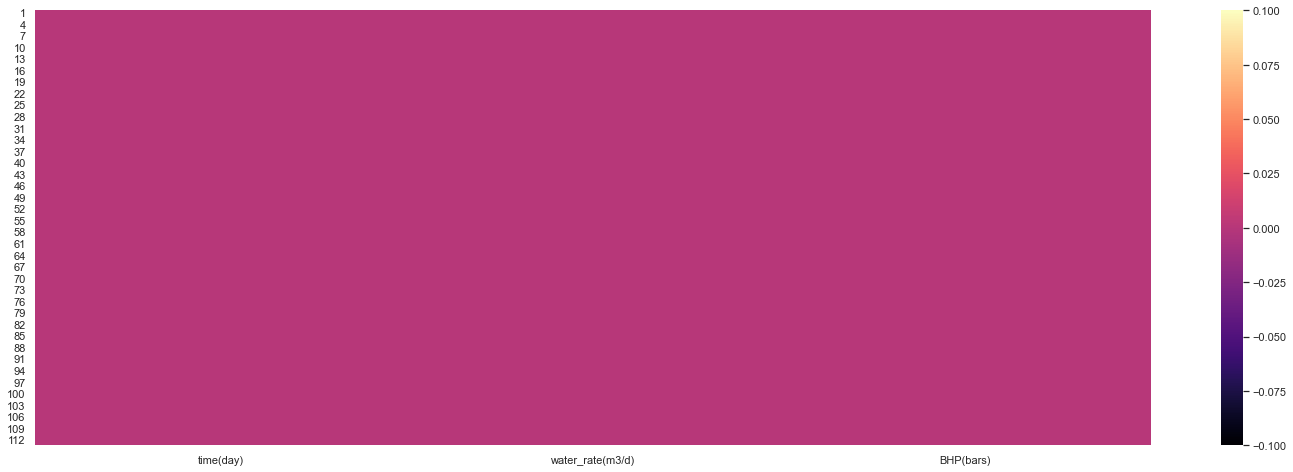

---------------Linear-Linear Plot---------------


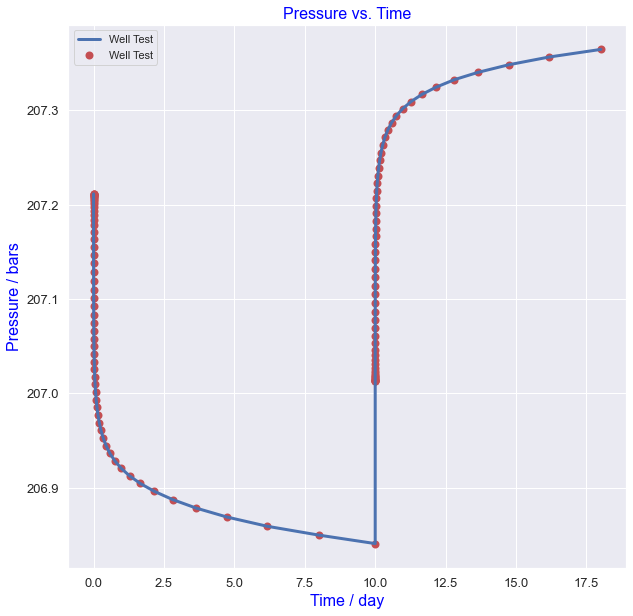

---------------Semi Log Plot---------------


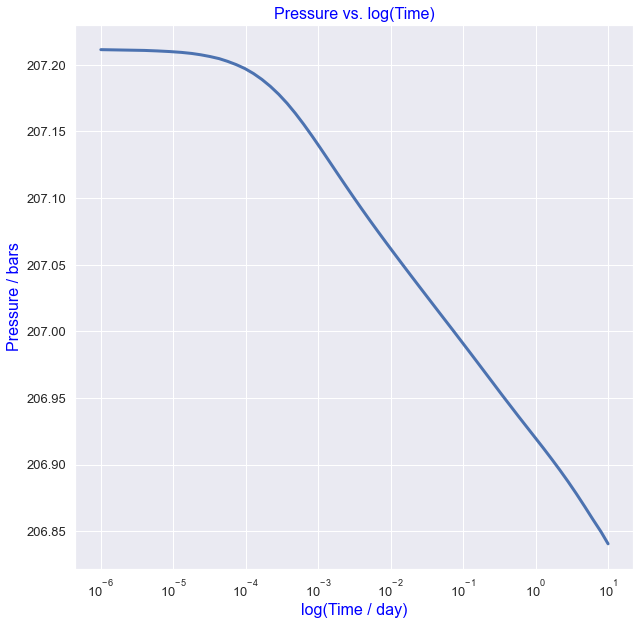

In [7]:
base_filename1 = 'E02_welltest'
df1 = interp_well(dir_name, base_filename1 , filename_suffix, font)

------------------Checking the Data---------------
   time(day)  water_rate(m3/d)   BHP(bars)
1   0.000001           200.001  208.453568
2   0.000002           200.000  208.453263
3   0.000004           200.000  208.453046
4   0.000006           200.000  208.452767
5   0.000009           200.000  208.452409
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1 to 113
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time(day)         113 non-null    float64
 1   water_rate(m3/d)  113 non-null    float64
 2   BHP(bars)         113 non-null    float64
dtypes: float64(3)
memory usage: 3.5 KB
None
------------------Checking for missing points visually---------------


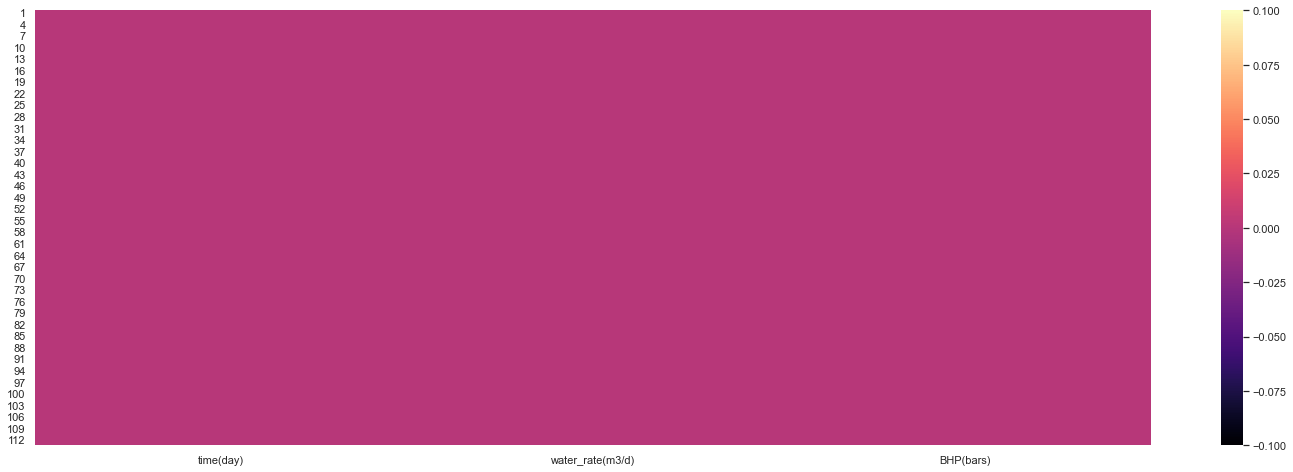

---------------Linear-Linear Plot---------------


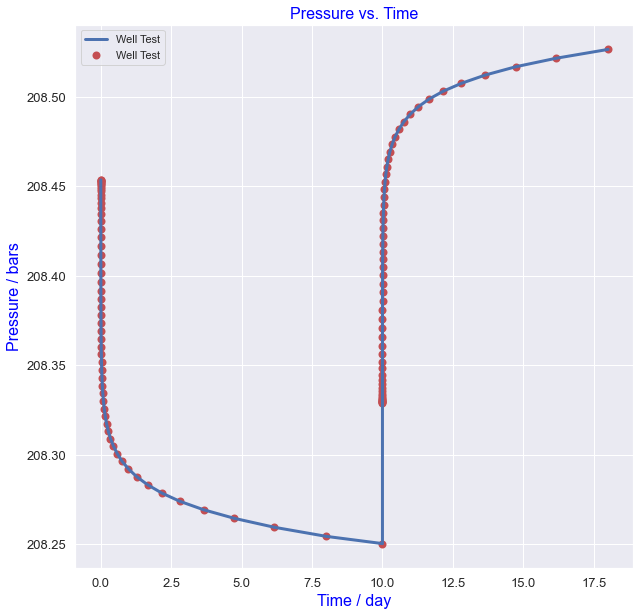

---------------Semi Log Plot---------------


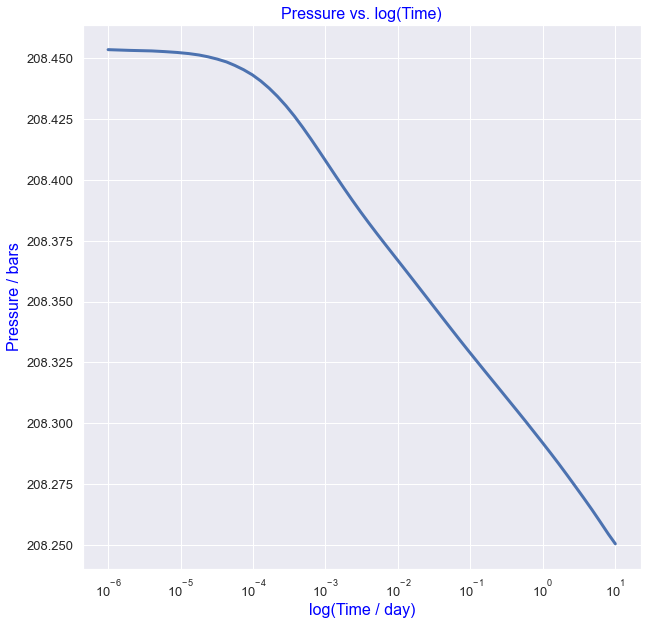

In [8]:
base_filename2 = 'E04_welltest'
df2 = interp_well(dir_name, base_filename2 , filename_suffix, font)

------------------Checking the Data---------------
   time(day)  water_rate(m3/d)   BHP(bars)
1   0.000002             200.0  211.457116
2   0.000004             200.0  211.456719
3   0.000006             200.0  211.456203
4   0.000009             200.0  211.455540
5   0.000013             200.0  211.454691
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 1 to 112
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time(day)         112 non-null    float64
 1   water_rate(m3/d)  112 non-null    float64
 2   BHP(bars)         112 non-null    float64
dtypes: float64(3)
memory usage: 3.5 KB
None
------------------Checking for missing points visually---------------


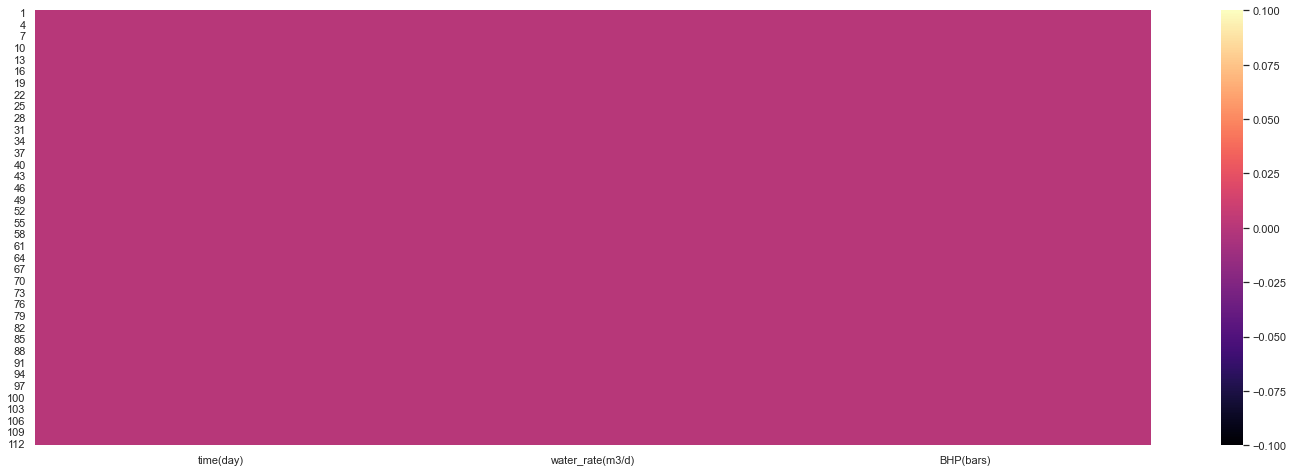

---------------Linear-Linear Plot---------------


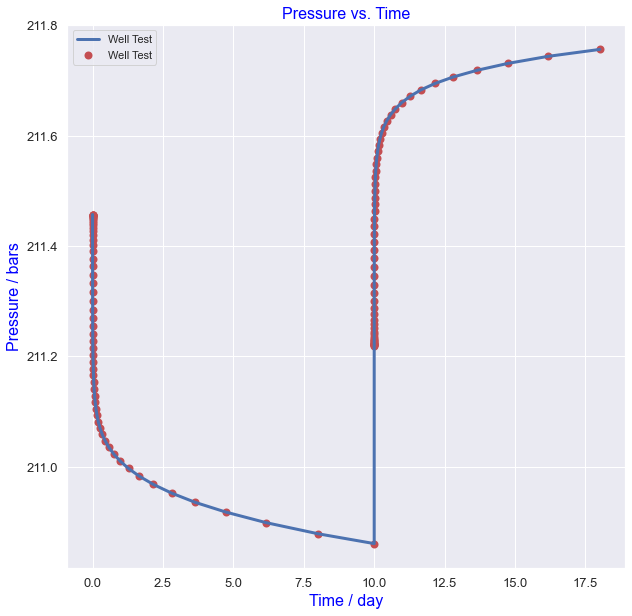

---------------Semi Log Plot---------------


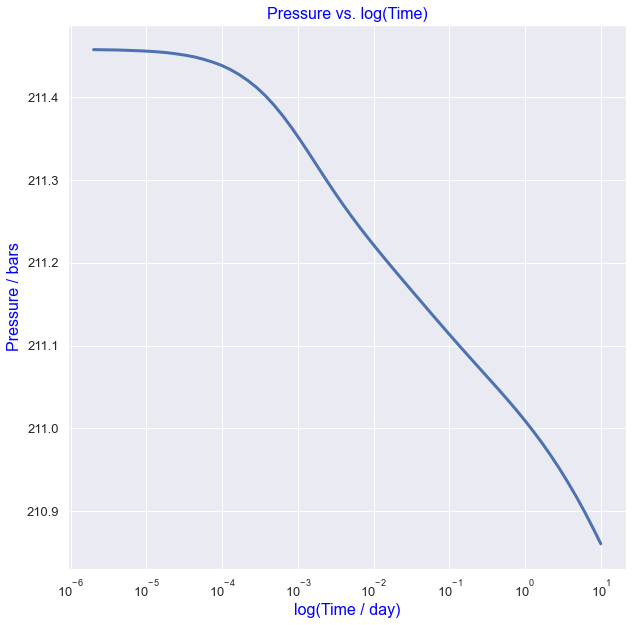

In [9]:
base_filename3 = 'E06_welltest'
df3 = interp_well(dir_name, base_filename3 , filename_suffix, font)

------------------Checking the Data---------------
   time(day)  water_rate(m3/d)   BHP(bars)
1   0.000001           200.001  209.939360
2   0.000002           200.000  209.938241
3   0.000004           200.000  209.937910
4   0.000006           200.000  209.937487
5   0.000009           200.000  209.936946
------------------Type of Data---------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1 to 113
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time(day)         113 non-null    float64
 1   water_rate(m3/d)  113 non-null    float64
 2   BHP(bars)         113 non-null    float64
dtypes: float64(3)
memory usage: 3.5 KB
None
------------------Checking for missing points visually---------------


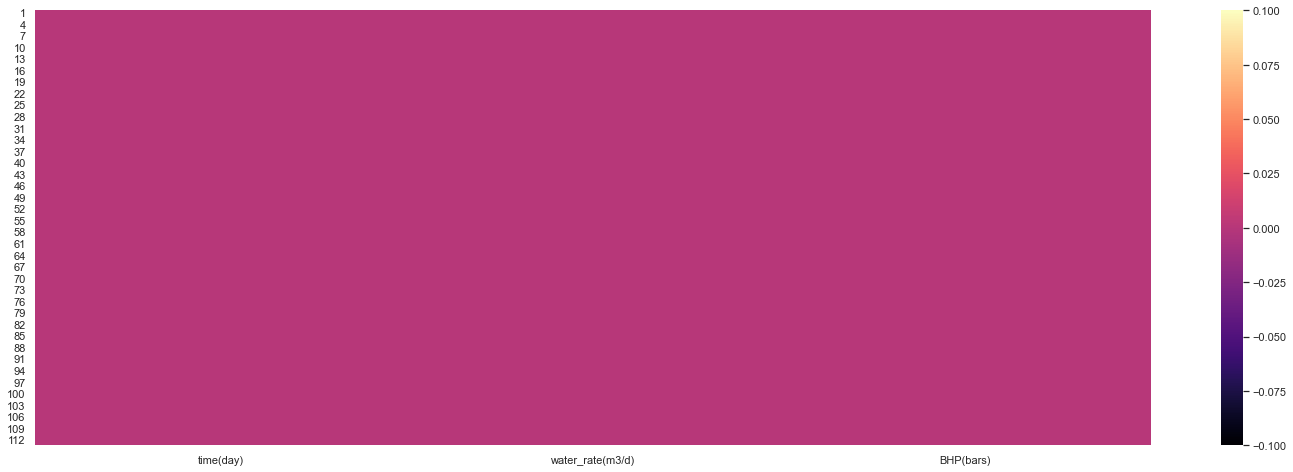

---------------Linear-Linear Plot---------------


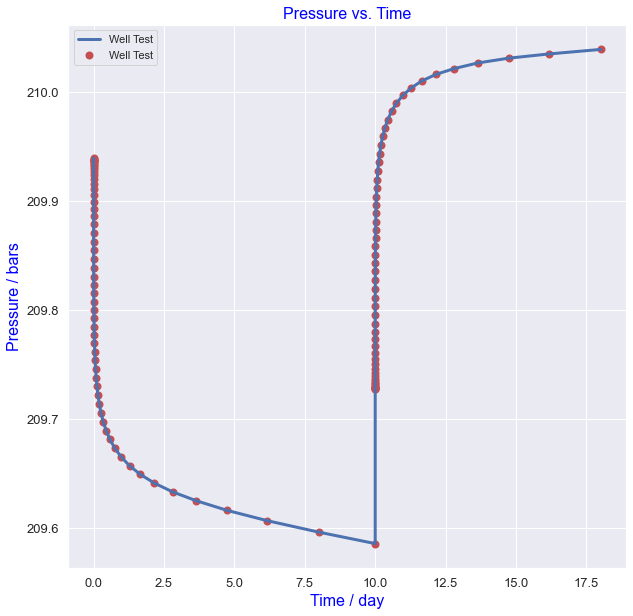

---------------Semi Log Plot---------------


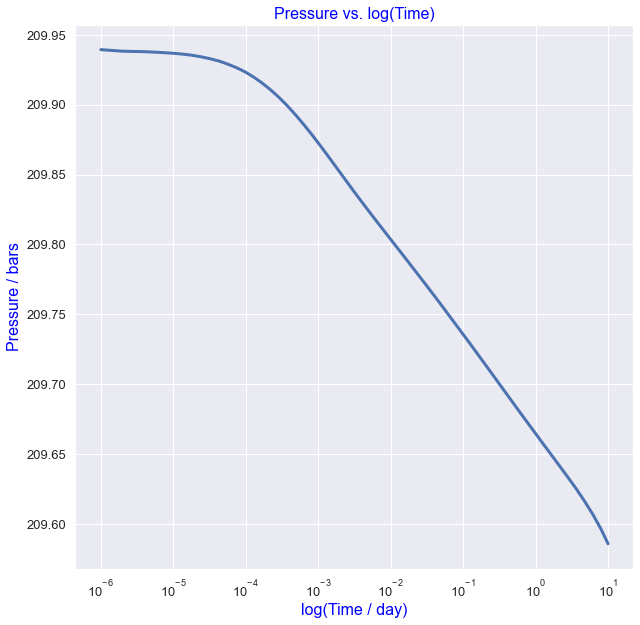

In [10]:
base_filename4 = 'P01_welltest'
df4 = interp_well(dir_name, base_filename4 , filename_suffix, font)

#### Part 2 - Interpretation of Permeability

***For Well 1 (E02), the linear flow regime is from 10^-3 to 5 day. This straight line "transient" flow will be evaluated for permeability***

---------------Linear Regression Model---------------
The coefficient is  [[-3142.79057678]]
The intercept is  [20727608.8042057]
---------------Plot the Results---------------


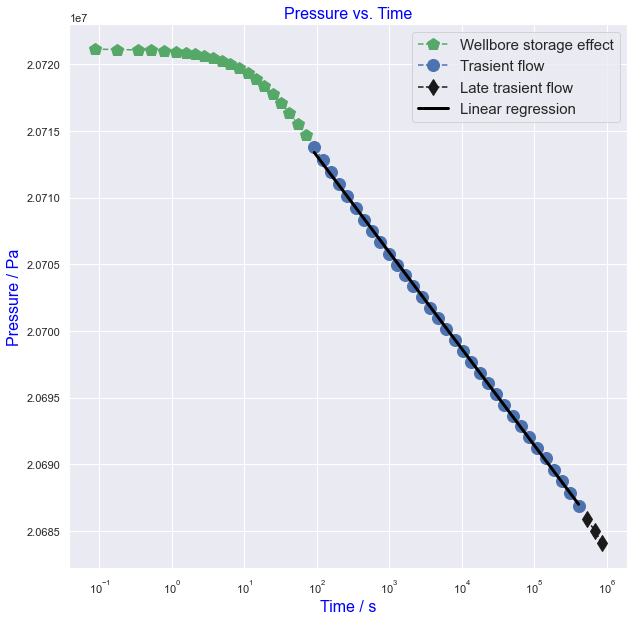

Permeability for Well  E02_welltest is  751.4435208017438 mD


In [11]:
lf_start = 10**-3
lf_end = 5

# Following is manually read from metadata as well as first line of data files
h = 2224 - 2146       # thickness, unit: m
q = 200               # rate, unit: m3/day

perm_eval1 = transient_flow_analysis(df1, lf_start, lf_end, h, q, font)
print("Permeability for Well ", base_filename1 , "is ", perm_eval1, "mD")

***For Well 2 (E04), the linear flow regime is from 5x10^-4 to 1 day. This straight line "transient" flow will be evaluated for permeability***

---------------Linear Regression Model---------------
The coefficient is  [[-1676.5036902]]
The intercept is  [20848115.18605136]
---------------Plot the Results---------------


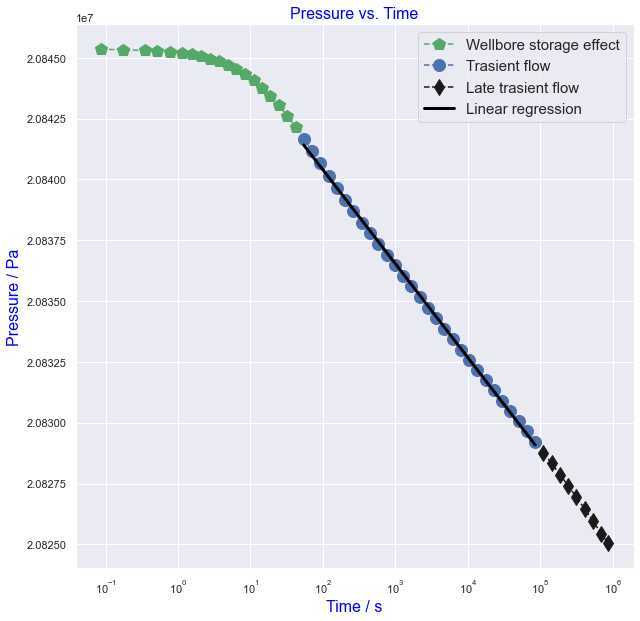

Permeability for Well  E04_welltest is  646.3279752864199 mD


In [12]:
lf_start = 5*10**-4
lf_end = 1

# Following is manually read from metadata as well as first line of data files
h = 2210 - 2040       # thickness, unit: m
q = 200               # rate, unit: m3/day

perm_eval2 = transient_flow_analysis(df2, lf_start, lf_end, h, q, font)
print("Permeability for Well ", base_filename2 , "is ", perm_eval2, "mD")

***For Well 3 (E06), the linear flow regime is from 5x10^-3 to 5x10^-1 day. This straight line "transient" flow will be evaluated for permeability***

---------------Linear Regression Model---------------
The coefficient is  [[-4645.03396626]]
The intercept is  [21153533.55229267]
---------------Plot the Results---------------


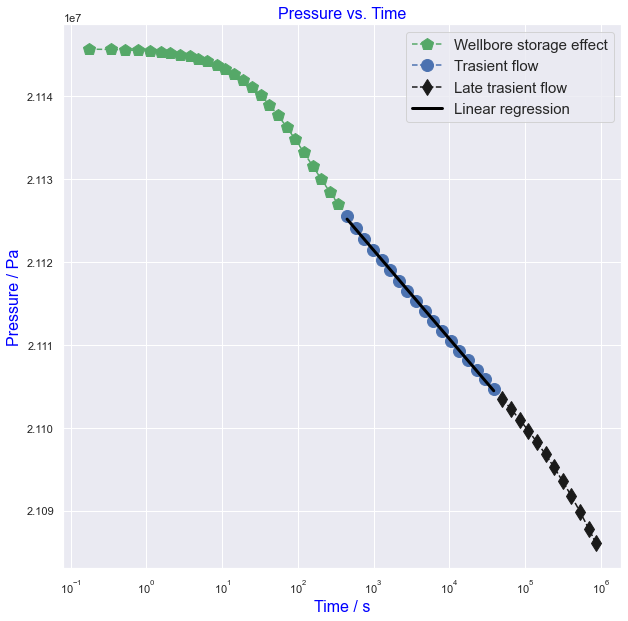

Permeability for Well  E06_welltest is  515.0231727105154 mD


In [13]:
lf_start = 5*10**-3
lf_end = 5*10**-1

# Following is manually read from metadata as well as first line of data files
h = 2045 - 1968       # thickness, unit: m
q = 200               # rate, unit: m3/day

perm_eval3 = transient_flow_analysis(df3, lf_start, lf_end, h, q, font)
print("Permeability for Well ", base_filename3 , "is ", perm_eval3, "mD")

***For Well 4 (P01), the linear flow regime is from 1x10^-3 to 1 day. This straight line "transient" flow will be evaluated for permeability***

---------------Linear Regression Model---------------
The coefficient is  [[-2993.8743045]]
The intercept is  [21000613.06324188]
---------------Plot the Results---------------


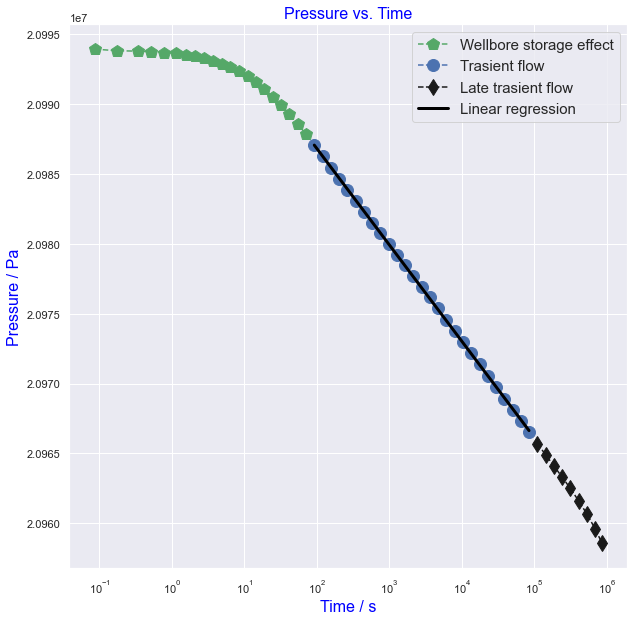

Permeability for Well  P01_welltest is  732.4762376074779 mD


In [14]:
lf_start = 1*10**-3
lf_end = 1

# Following is manually read from metadata as well as first line of data files
h = 2351 - 2267       # thickness, unit: m
q = 200               # rate, unit: m3/day

perm_eval4 = transient_flow_analysis(df4, lf_start, lf_end, h, q, font)
print("Permeability for Well ", base_filename4 , "is ", perm_eval4, "mD")

Write out a file with all the values

In [15]:
import linecache

# Reads out the text lines of metadata without reading in the whole file.
csvs_sht1 = os.path.join(dir_name, base_filename1 + '.' + filename_suffix)
lineout1 = linecache.getlines(csvs_sht1)[2:7]

csvs_sht2 = os.path.join(dir_name, base_filename2 + '.' + filename_suffix)
lineout2 = linecache.getlines(csvs_sht2)[2:7]

csvs_sht3 = os.path.join(dir_name, base_filename3 + '.' + filename_suffix)
lineout3 = linecache.getlines(csvs_sht3)[2:7]

csvs_sht4 = os.path.join(dir_name, base_filename4 + '.' + filename_suffix)
lineout4 = linecache.getlines(csvs_sht4)[2:7]

# Create a pandas dataframe; linecache includes all line breaks so that has to be split and replaced
df_out = pd.DataFrame(lineout1) + pd.DataFrame(lineout2) + pd.DataFrame(lineout3) + pd.DataFrame(lineout4)
df_out = df_out.replace(r'\n',' ', regex=True) 
df_out = df_out[0].str.split(":", expand=True,)

#Transpore the row format into column and read first row as header. Index has not been reset
df_out = df_out.transpose()
df_out.columns = df_out.iloc[0]
df_out.drop(index=df_out.index[0], axis=0, inplace=True)

# Clean up of some of the messy rows
df_out['Well name'] = df_out['Well name'].str.replace('Well name','')
df_out['Perforation interval'] = df_out['Perforation interval'].str.replace('Perforation interval','')
df_out['Fluid in place'] = df_out['Fluid in place'].str.replace('Fluid in place','')
df_out['Initial pressure'] = df_out['Initial pressure'].str.replace('Initial pressure','')
df_out['Temperature'] = df_out['Temperature'].str.replace('Temperature','')

# Create a dummy column and fill in row-wise permeability evaluated earlier
df_out['Permeability (mD)'] = 0
df_out.loc[[1],["Permeability (mD)"]] = perm_eval1
df_out.loc[[2],["Permeability (mD)"]] = perm_eval2
df_out.loc[[3],["Permeability (mD)"]] = perm_eval3
df_out.loc[[4],["Permeability (mD)"]] = perm_eval4

#Rename columns
columns = {'Well name':'Well',
           'Perforation interval':'Perf',
           'Fluid in place':'Fluid',
           'Initial pressure':'Initial Pressure (bars)',
           'Temperature':'Initial Temperature (DegC)',
           'Permeability (mD)':'Permeability (mD)',
}

# Output
df_out.rename(columns=columns, inplace=True)
print("---------------Interpreted Permeabilities---------------")
print(df_out)

final_filename = 'Perm_From_Well_test'
csvs_sht0 = os.path.join(dir_name, final_filename + '.' + filename_suffix2)
print("---------------Write out File---------------")
df_out.to_csv(csvs_sht0, index = False, header=True)

---------------Interpreted Permeabilities---------------
0   Well            Perf    Fluid Initial Pressure (bars)  \
1   E02    2146 to 2224    brine                 207.362    
2   E04    2040 to 2210    brine                 208.488    
3   E06    1968 to 2045    brine                 211.775    
4   P01    2267 to 2351    brine                 210.037    

0 Initial Temperature (DegC)  Permeability (mD)  
1                   346.643          751.443521  
2                   358.424          646.327975  
3                   347.082          515.023173  
4                   352.399          732.476238  
---------------Write out File---------------


### Conclusion

In [16]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 9.840026140213013 seconds
